In [49]:
import numpy as np
import matplotlib.pylab as plt
import uproot
import awkward as ak
import seaborn
import RA_funcs as rf

<span style="font-family: arial; font-size:25px; color:pink">

Open ROOT file and extract data

In [50]:
file_name = "TB_FIRE_1101_hits.root"
hit_data_1101 = rf.get_ROOT_data_zip(file_name)

Folders: ['Hits;1']

Hits:
name                 | typename                 | interpretation                
---------------------+--------------------------+-------------------------------
TLU_number           | uint64_t                 | AsDtype('>u8')
timestamp            | std::vector<uint64_t>    | AsJagged(AsDtype('>u8'), he...
plane_ID             | std::vector<int32_t>     | AsJagged(AsDtype('>i4'), he...
ch_ID                | std::vector<int32_t>     | AsJagged(AsDtype('>i4'), he...
amplitude            | std::vector<int32_t>     | AsJagged(AsDtype('>i4'), he...
toa                  | std::vector<int32_t>     | AsJagged(AsDtype('>i4'), he...


In [55]:
hit_data_1101

<Array [[{plane: 0, ch: 128, ...}, ...], ...] type='2356797 * var * {plane:...'>

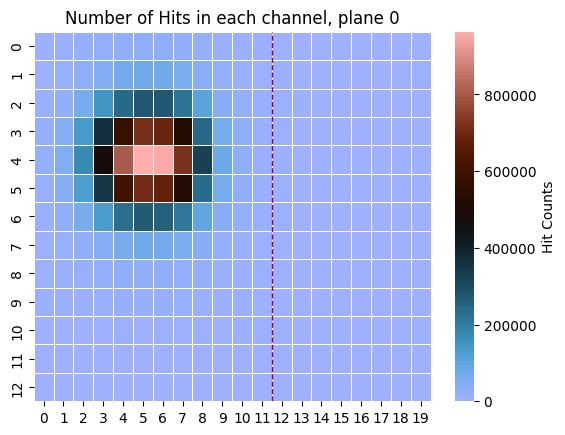

In [51]:
rf.hits_amount_colormap_single_plane(hit_data_1101, 0)

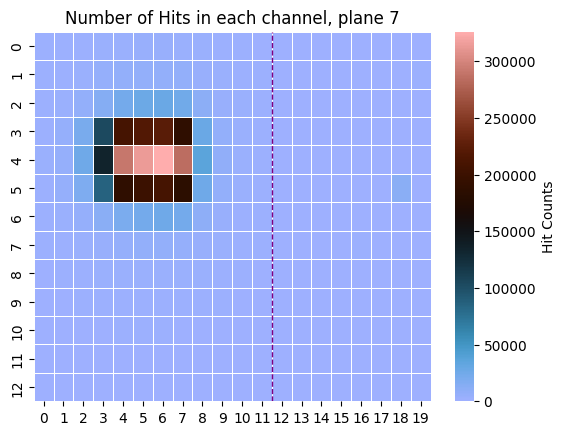

In [52]:
rf.hits_amount_colormap_single_plane(hit_data_1101, 7)

In [53]:
hit_data_1101[0]

<Array [{plane: 0, ch: 128, ...}, ..., {...}] type='28 * {plane: int32, ch:...'>

In [54]:
plt.hist()

TypeError: hist() missing 1 required positional argument: 'x'

In [56]:
# rf.single_event_evolution_amp(hit_data_1101, 50, cmap="managua")

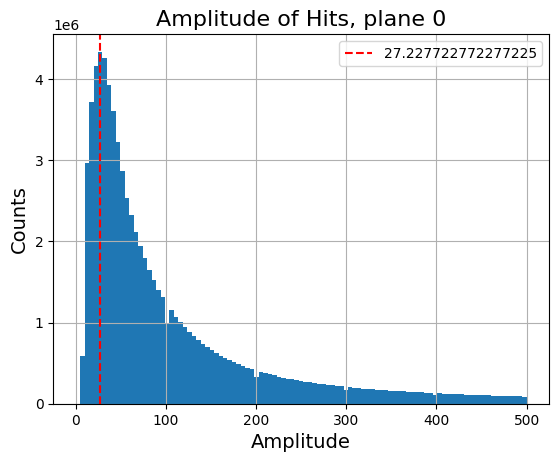

In [58]:
# histogram of amplitudes in first layers
hit_plane_0 = hit_data_1101[hit_data_1101.plane == 7]
hit_plane_0_amp = hit_data_1101.amp

counts, bins, patches = plt.hist(ak.flatten(hit_plane_0_amp), bins=101, range=(0,500))
max_bin_index = np.argmax(counts)
max_bin_center = (bins[max_bin_index] + bins[max_bin_index + 1]) / 2
max_inputs = np.round(max_bin_center)

plt.axvline(max_inputs, color='red', linestyle='--', label= max_bin_center)
plt.legend()
plt.grid()
plt.title('Amplitude of Hits, plane 0', fontsize=16)
plt.xlabel('Amplitude', fontsize=14)
plt.ylabel('Counts', fontsize=14)
plt.show()


In [ ]:
# get the reduced energy vs plane in a graph
def average_amp_vs_plane(hit_data):

    # total amount of events in the run(TLU's)
    events = len(hit_data)

    # list of planes
    planes = np.arange(0,8,1)

    # create a list of total energy(amp) for each plane
    amp_list = []

    # get the amp for each plane
    for plane in range(7,-1,-1):
    
        # get only the hits on the wanted plane
        hits_plane_n = hit_data[hit_data.plane == plane]

        # clean data from empty cells
        clean_plane_n = hits_plane_n[ak.num(hits_plane_n.ch) > 0]

        # count the amplitude for every plane
        plane_pad_amp = clean_plane_n.amp                  # get only the amplitudes of the given pad in the plane
        plane_total_amp = ak.sum(plane_pad_amp)             # sum all the amplitudes
        amp_list.append(plane_total_amp)

    # print the graph of average energy vs plane

    plt.figure(figsize=(8, 5))
    plt.plot(planes, amp_list, marker='o')
    plt.xlabel('Plane')
    plt.ylabel('Energy')
    plt.title('Graph of x vs y')
    plt.grid(True)
    plt.show()


        

In [ ]:
len(hit_data_1101)

2356797